# BB Retrain Strategy: Execution Patterns

This notebook demonstrates how to execute each of the four main patterns using the refactored modular code. Each section below runs one pattern and provides a place to analyze results.

## Load the model and test its accuracy


In [1]:
import torch
# Load the model and test its accuracy
from RESNETEE import ResNet18AutoEarlyExits
from spliter import split_cifar10_dataset
from evaluate import accuracy_EE_byclass
from torch.utils.data import DataLoader, Subset
model_with_exits = ResNet18AutoEarlyExits()
model_with_exits.load_state_dict(torch.load('model_with_exits_new.pth'))
model_with_exits.cuda()
# model_with_exits.train()  # 默认开启训练模式以支持后续 retrain
model_with_exits.eval()  # 切换到评估模式
# Example: Evaluate accuracy on test set
datasets = split_cifar10_dataset()

if datasets is not None:
	train_dataset_1, train_dataset_2, test_dataset = datasets
	print(f'Dataset 1 size: {len(train_dataset_1)}')
	print(f'Dataset 2 size: {len(train_dataset_2)}')
	train_loader_1 = DataLoader(train_dataset_1, batch_size=64, shuffle=True)
	train_loader_2 = DataLoader(train_dataset_2, batch_size=64, shuffle=True)
	test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)
else:
	print("split_cifar10_dataset() returned None. Please check its implementation.")





C:\Users\Zhao\AppData\Local\Temp\ipykernel_11948\705956629.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_with_exits.load_state_dict(torch.load('model_with_exits_

Files already downloaded and verified
Files already downloaded and verified
Dataset 1 size: 25000
Dataset 2 size: 25000


In [ ]:

acc1 = accuracy_EE_byclass(model_with_exits, test_loader, return_exit1=True, return_exit2=False)

acc2 = accuracy_EE_byclass(model_with_exits, test_loader, return_exit1=False, return_exit2=True)

acc3 = accuracy_EE_byclass(model_with_exits, test_loader, return_exit1=False, return_exit2=False)

import pandas as pd

results = {
    "Exit 1 Only": acc1,
    "Exit 2 Only": acc2,
    "Main Exit Only": acc3
}
df = pd.DataFrame(results)
print(df)

### The model is primarily trained with airpalne automobile ship truck for EE1, airplane automobile bird deer dog for EE2.
 Then we change the priority of classes to:
          most popular :'airplane''automobile''bird''cat'
           second popular :     'deer' 'dog' 'frog'


In [2]:
# training data prepared for retraining EE1

# Function to filter dataset by classes
def filter_by_classes(dataset, classes_to_include):
    class_indices = [dataset.class_to_idx[cls] for cls in classes_to_include]
    indices = [i for i, (_, label) in enumerate(dataset.samples) if label in class_indices]
    return Subset(dataset, indices)

# Define the four classes and the remaining six classes
classes_subset1a = ['airplane', 'automobile', 'bird', 'cat'] 
classes_subset1b =  ['ship', 'truck','deer', 'dog', 'frog', 'horse'] # Remaining classes 

# Create subsets for the four classes and the other six classes
subset1a = {'train':filter_by_classes(train_dataset_1, classes_subset1a),
              'test':filter_by_classes(test_dataset, classes_subset1a)}
subset1b = {'train':filter_by_classes(train_dataset_1, classes_subset1b),
            'test':filter_by_classes(test_dataset, classes_subset1b)}
# Create DataLoaders for each subset
dataloaders_subset1a = {
    'train': DataLoader(subset1a['train'], batch_size=64, shuffle=True, num_workers=4),
    'test': DataLoader(subset1a['test'], batch_size=64, shuffle=False, num_workers=4)
}
dataloaders_subset1b = {
    'train': DataLoader(subset1b['train'], batch_size=64, shuffle=True, num_workers=4),
    'test': DataLoader(subset1b['test'], batch_size=64, shuffle=False, num_workers=4)
}

# training data prepared for retraining EE2
# Define the four classes and the remaining six classes
classes_subset2a = ['airplane','automobile', 'bird','cat','deer', 'dog','frog' ]
classes_subset2b =  [ 'horse','ship', 'truck'] # Remaining classes 
# Create subsets for the four classes and the other six classes
subset2a = {'train':filter_by_classes(train_dataset_1, classes_subset2a),
              'test':filter_by_classes(test_dataset, classes_subset2a)}
subset2b = {'train':filter_by_classes(train_dataset_1, classes_subset2b),
            'test':filter_by_classes(test_dataset, classes_subset2b)}
# Create DataLoaders for each subset
dataloaders_subset2a = {
    'train': DataLoader(subset2a['train'], batch_size=64, shuffle=True, num_workers=4),
    'test': DataLoader(subset2a['test'], batch_size=64, shuffle=False, num_workers=4)
}
dataloaders_subset2b = {
    'train': DataLoader(subset2b['train'], batch_size=64, shuffle=True, num_workers=4),
    'test': DataLoader(subset2b['test'], batch_size=64, shuffle=False, num_workers=4)
}
# train_loader_1, train_loader_2    # already defined above

# Single Exit training profiling

In [3]:
def run_with_profiler(run_fn, log_name='default_profiler_log', steps=5, *args, **kwargs):
    """
    Run a given function with torch.profiler enabled, tracing CPU/CUDA performance.

    Parameters:
    - run_fn: the target function to execute (e.g., run_shared_parallel_execution)
    - log_name: the output directory name for the profiler logs (under ./log/)
    - steps: how many steps of profiling to activate (affects visualization granularity)
    - *args, **kwargs: arguments to pass to run_fn

    Returns:
    - the result of run_fn(*args, **kwargs)
    """
    import os
    from torch.profiler import profile, ProfilerActivity, tensorboard_trace_handler
    os.makedirs(f'./log/{log_name}', exist_ok=True)

    with profile(
        activities=[ProfilerActivity.CPU, ProfilerActivity.CUDA],
        schedule=torch.profiler.schedule(wait=1, warmup=1, active=steps),
        on_trace_ready=tensorboard_trace_handler(f'./log/{log_name}'),
        record_shapes=True,
        profile_memory=True,
        with_stack=True
    ) as prof:
        result = run_fn(*args, **kwargs)
        for _ in range(steps):
            prof.step()

    return result

In [4]:


from controllers import run_single_exit_training

run_with_profiler(
    run_fn=run_single_exit_training,
    log_name='prof_train_EE1',
    steps=5,
    model=model_with_exits,
    dataloaders_subset_a=dataloaders_subset1a,
    dataloaders_subset_b=dataloaders_subset1b,
    exit_number=1
)

[SingleExit] 启动训练线程 Exit1 ...

Epoch 1/5
----------
test Acc: 93.45000
Train Loss: 0.3204 | ID Acc: 0.8658 | OOD Certainty: 0.2580

Epoch 2/5
----------
test Acc: 93.45000
Train Loss: 0.1977 | ID Acc: 0.9391 | OOD Certainty: 0.2391

Epoch 3/5
----------
test Acc: 93.50000
Train Loss: 0.1713 | ID Acc: 0.9480 | OOD Certainty: 0.2283

Epoch 4/5
----------
test Acc: 93.45000
Train Loss: 0.1554 | ID Acc: 0.9564 | OOD Certainty: 0.2216

Epoch 5/5
----------
test Acc: 93.60000
Train Loss: 0.1463 | ID Acc: 0.9548 | OOD Certainty: 0.2139
[训练 Exit1 耗时] 耗时: 157.57 秒

[SingleExit] Exit1 训练完成


## Pattern A Execution
Run the early exits training and main brabch only inference workflow.

C:\Users\Zhao\AppData\Local\Temp\ipykernel_7912\2433265924.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_with_exits.load_state_dict(torch.load('model_with_exits

[FullSuspension] 启动推理线程...[FullSuspension] 第一阶段：训练 Exit1 (Exit2 和主干处理推理)...


Epoch 1/5
----------
test Acc: 93.47500
Train Loss: 0.3171 | ID Acc: 0.8647 | OOD Certainty: 0.2577

Epoch 2/5
----------
test Acc: 93.27500
Train Loss: 0.2006 | ID Acc: 0.9344 | OOD Certainty: 0.2406

Epoch 3/5
----------
[FullSuspension] 推理线程结束
test Acc: 93.27500
Train Loss: 0.1699 | ID Acc: 0.9473 | OOD Certainty: 0.2286

Epoch 4/5
----------
test Acc: 93.27500
Train Loss: 0.1506 | ID Acc: 0.9611 | OOD Certainty: 0.2195

Epoch 5/5
----------
test Acc: 93.30000
Train Loss: 0.1404 | ID Acc: 0.9624 | OOD Certainty: 0.2141
[训练 Exit1 耗时] 耗时: 158.30 秒

[FullSuspension] 第二阶段：训练 Exit2 (Exit1 和主干处理推理)...

Epoch 1/5
----------
test Acc: 94.90000
Train Loss: 0.1250 | ID Acc: 0.9849 | OOD Certainty: 0.1281

Epoch 2/5
----------
test Acc: 94.87143
Train Loss: 0.0237 | ID Acc: 0.9945 | OOD Certainty: 0.1102

Epoch 3/5
----------
test Acc: 94.85714
Train Loss: 0.0194 | ID Acc: 0.9955 | OOD Certainty: 0.1083

Epoch 4/5
--

NameError: name 'plt' is not defined

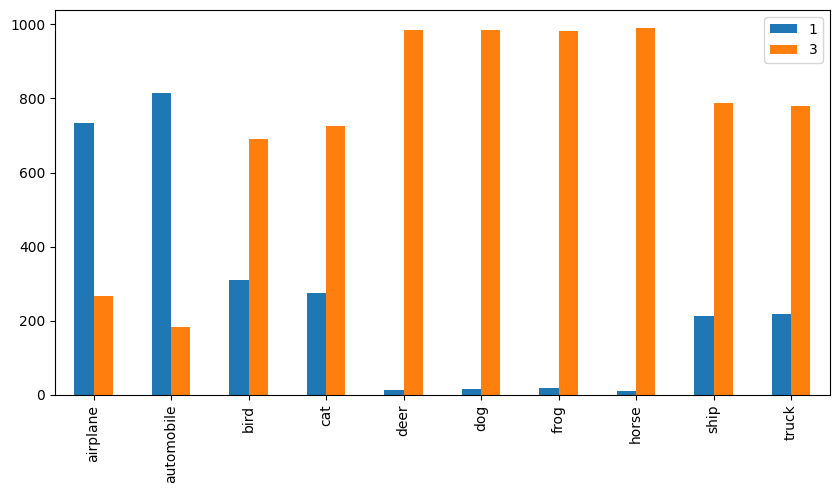

In [ ]:
# Imports and setup for all patterns
from controllers import *
from data_utils import *
from evaluate import *
from training import *
from monitor import *


# ... (add any other setup or utility imports needed)

model_with_exits.load_state_dict(torch.load('model_with_exits_new.pth'))
model_with_exits.cuda()
# model_with_exits.train()  # 默认开启训练模式以支持后续 retrain
model_with_exits.eval()  # 切换到评估模式
model = model_with_exits  # Use the previously defined model

# dataloaders_subset1a = ...
# dataloaders_subset1b = ...
# dataloaders_subset2a = ...
# dataloaders_subset2b = ...
# === 创建两个控制器实例 ===


controller1 = TrainingController()  # 控制 Exit1 的训练
controller2 = TrainingController()  # 控制 Exit2 的训练
results, latency_logs, exit_logs = run_full_suspension_parallel_realtime_logging(
    model_with_exits,
    dataloaders_subset1a,
    dataloaders_subset1b,
    dataloaders_subset2a,
    dataloaders_subset2b,
    controller1,
    controller2,
    test_loader,
    Timer,
    trainEE_KL,
    device='cuda',
    visualize=True
)
# inference_loader = ...
# Timer = ...
# trainEE_KL = ...
# _visualize_exit_distribution = ...
# analyze_exit_logs_with_accuracy = ...
# class_names = ...

## Pattern B Execution
Run the two-stage training and inference workflow (Pattern B).

In [6]:
# Run Pattern B Execution
results_b, latency_logs_b, exit_logs_b = run_patternB_execution(
    model,
    dataloaders_subset1a,
    dataloaders_subset1b,
    dataloaders_subset2a,
    dataloaders_subset2b,
    controller1,
    controller2,
    inference_loader,
    Timer,
    trainEE_KL,
    _visualize_exit_distribution,
    analyze_exit_logs_with_accuracy,
    device='cuda'
)
results_b

NameError: name 'model' is not defined

## Pattern O (No Training) Execution
Run the inference-only workflow (Pattern O).

In [ ]:
# Run Pattern O (No Training) Execution
results_o, latency_logs_o, exit_logs_o = run_pattern_O_no_training(
    model,
    inference_loader,
    _visualize_exit_distribution,
    analyze_exit_logs_with_accuracy,
    class_names,
    device='cuda'
)
results_o

## Full Suspension Parallel Realtime Logging Execution
Run the full suspension parallel training and inference workflow.

In [ ]:
# Run Full Suspension Parallel Realtime Logging Execution
results_full, latency_logs_full, exit_logs_full = run_full_suspension_parallel_realtime_logging(
    model,
    dataloaders_subset1a,
    dataloaders_subset1b,
    dataloaders_subset2a,
    dataloaders_subset2b,
    controller1,
    controller2,
    inference_loader,
    Timer,
    trainEE_KL,
    _visualize_exit_distribution,
    analyze_exit_logs_with_accuracy,
    device='cuda'
)
results_full

## Shared Parallel Execution
Run the shared parallel training and inference workflow.

In [ ]:
# Run Shared Parallel Execution
results_shared, latency_logs_shared, exit_logs_shared = run_shared_parallel_execution(
    model,
    controller1,
    controller2,
    inference_loader,
    dataloaders_subset1a,
    dataloaders_subset1b,
    dataloaders_subset2a,
    dataloaders_subset2b,
    Timer,
    trainEE_KL,
    _visualize_exit_distribution,
    analyze_exit_logs_with_accuracy,
    class_names,
    device='cuda'
)
results_shared